In [1]:
# import all libaries 
import pandas as pd 
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split  

sns.set_theme()

import shap 
# scaling 
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier 

# metrics 
from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report,
                             roc_auc_score,roc_curve,
                             ConfusionMatrixDisplay,
                             recall_score,precision_score,f1_score)
# for tuning the model 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold


import scipy.stats as stats 
import warnings 
warnings.filterwarnings('ignore')

import joblib
from imblearn.over_sampling import SMOTE

In [2]:
# load the cleaned datasets 
df=pd.read_csv("cleaned_loan_predictions.csv")
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,0.0,14.0,34.818262
2,1,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,1500.0,65019.0,89235.5,Not Specified,No Job,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,41600.0,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,41600.0,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,41600.0,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,41600.0,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


# Model Building 

In [3]:
# 1.Encode Categorical Features
for col in df.select_dtypes(include='object').columns.tolist():
    encoder=LabelEncoder()
    df[col]=encoder.fit_transform(df[col])

# 2. Create Interaction & Ratio Features
df['LOAN_TO_VALUE'] = df['LOAN'] / df['VALUE']
df['LOAN_TO_MORTDUE'] = df['LOAN'] / df['MORTDUE']
df['EMI'] = df['LOAN'] / 12
df['CLAGE_PER_CLNO'] = df['CLAGE'] / df['CLNO']
df['DEROG_DELINQ_SUM'] = df['DEROG'] + df['DELINQ']

# 3. Binning (YOJ and CLAGE)
df['YOJ_BINNED'] = pd.cut(df['YOJ'], bins=[-1, 2, 5, 10, 20], labels=["0-2", "2-5", "5-10", "10+"])
df['CLAGE_BINNED'] = pd.cut(df['CLAGE'], bins=[0, 60, 120, 180, 240], labels=["0-60", "60-120", "120-180", "180+"])

binned_columns=['YOJ_BINNED', 'CLAGE_BINNED']
for cols in binned_columns:
    encoder=LabelEncoder()
    df[cols]=encoder.fit_transform(df[cols])

# Final dataset shape after feature engineering
df.shape

(5960, 20)

In [4]:
# Separate features and target
X = df.drop('BAD', axis=1)
y = df['BAD']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)


In [5]:

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,stratify=y,random_state=1)
# Step 2: Standardization
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train_scaled, y_train)

# Step 4: Model Definitions with Extended Hyperparameters
models_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(),
        {'max_depth': [3, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1]}
    )
}

# Step 5: Training, Evaluation, and Model Selection
results = []
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, params) in models_params.items():
    grid = GridSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1)
    grid.fit(x_train_res, y_train_res)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(x_test_scaled)
    y_proba = best_model.predict_proba(x_test_scaled)[:, 1]

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

# Create a DataFrame of all results
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

import joblib
import json
from datetime import datetime

# Step 6: Save the Best Model
best_model_name = results_df.iloc[0]['Model']
final_model = best_models[best_model_name]

# Create version timestamp
version_date = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create base filename
base_filename = f'best_model_{best_model_name.replace(" ", "_")}_{version_date}'

# Save the model in .pkl format
model_path_pkl = f'../best_model/{base_filename}.pkl'
joblib.dump(final_model, model_path_pkl)

# Create and save metadata in .json format
metadata = {
    'model_name': best_model_name,
    'version': version_date,
    'creation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'performance_metrics': results_df.iloc[0].to_dict(),
    'model_path': model_path_pkl
}

metadata_path = f'../best_model/{base_filename}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

# Update results_df with paths
results_df.loc[results_df.index[0], 'model_path_pkl'] = model_path_pkl
results_df.loc[results_df.index[0], 'metadata_path_json'] = metadata_path

# Return both paths for reference
model_paths = {
    'pkl': model_path_pkl,
    'json': metadata_path
}

results_df, model_paths

(                 Model                                        Best Params  \
 2        Random Forest  {'max_depth': None, 'min_samples_split': 2, 'n...   
 3              XGBoost  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...   
 1        Decision Tree          {'max_depth': 15, 'min_samples_split': 2}   
 0  Logistic Regression                 {'C': 0.01, 'solver': 'liblinear'}   
 
    Accuracy  Precision    Recall  F1 Score       AUC  \
 2  0.907718   0.790909  0.731092  0.759825  0.953615   
 3  0.910515   0.822951  0.703081  0.758308  0.944561   
 1  0.830537   0.565534  0.652661  0.605982  0.771750   
 0  0.627517   0.306148  0.683473  0.422877  0.720487   
 
                                       model_path_pkl  \
 2  ../best_model/best_model_Random_Forest_2025042...   
 3                                                NaN   
 1                                                NaN   
 0                                                NaN   
 
                                  

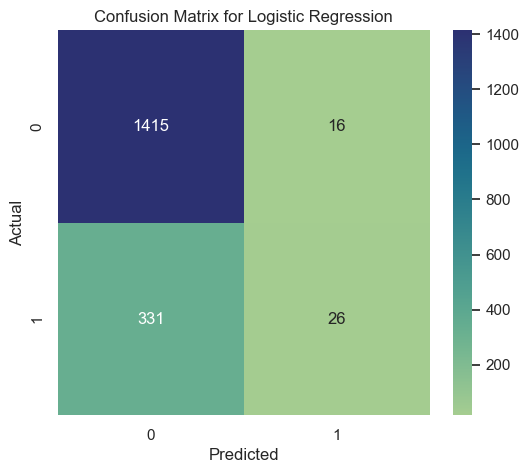

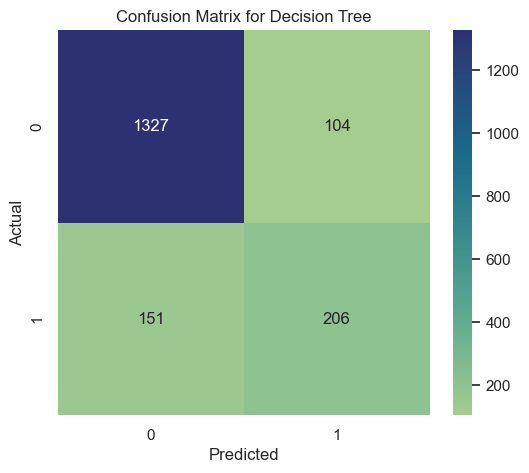

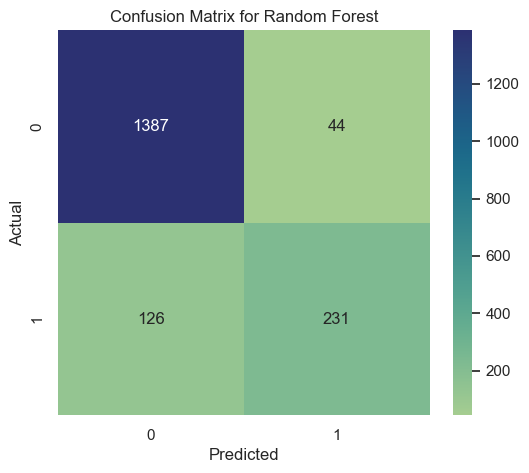

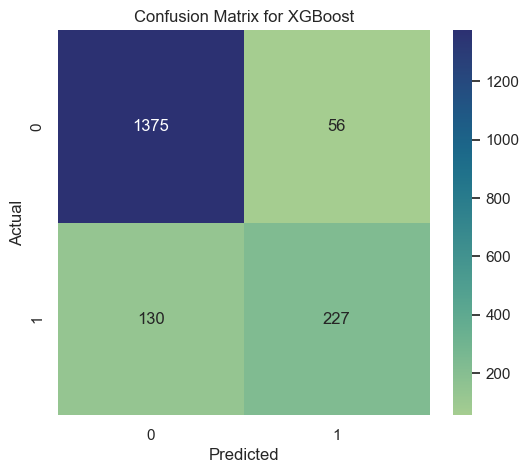

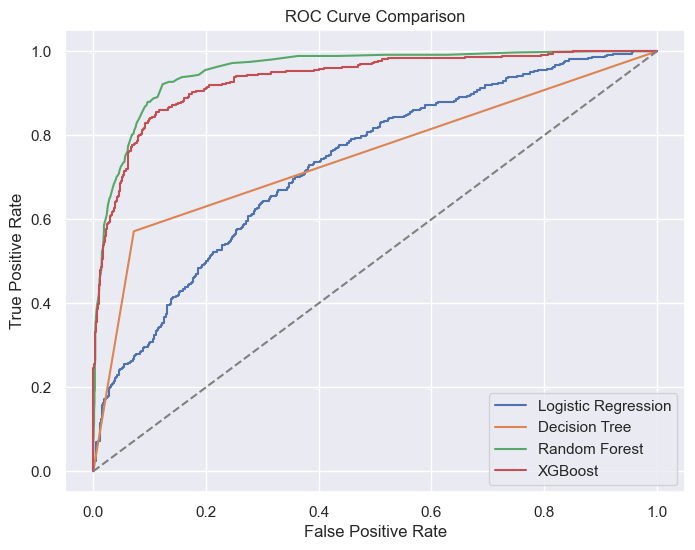

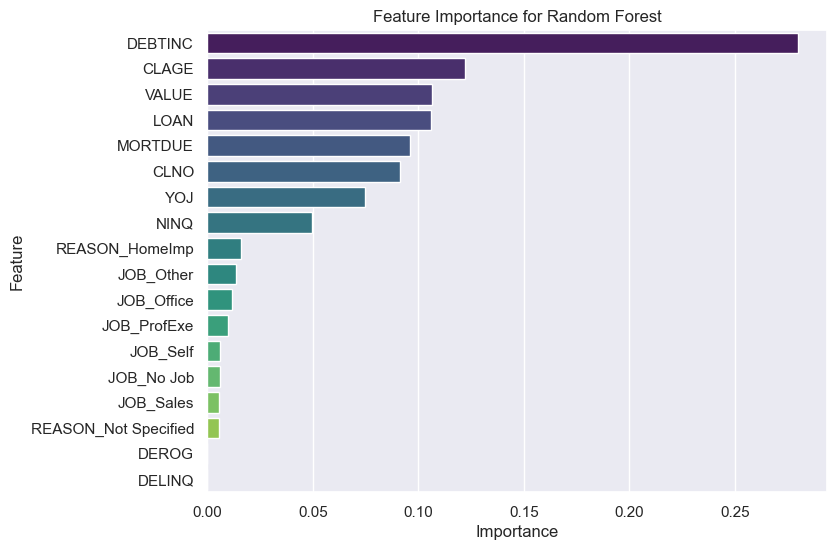

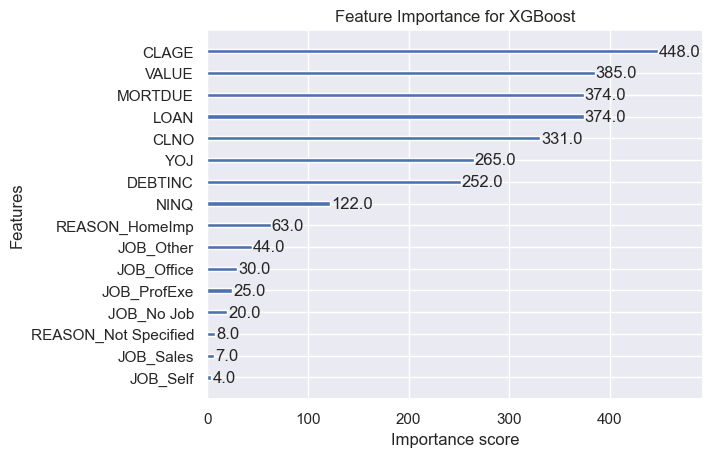

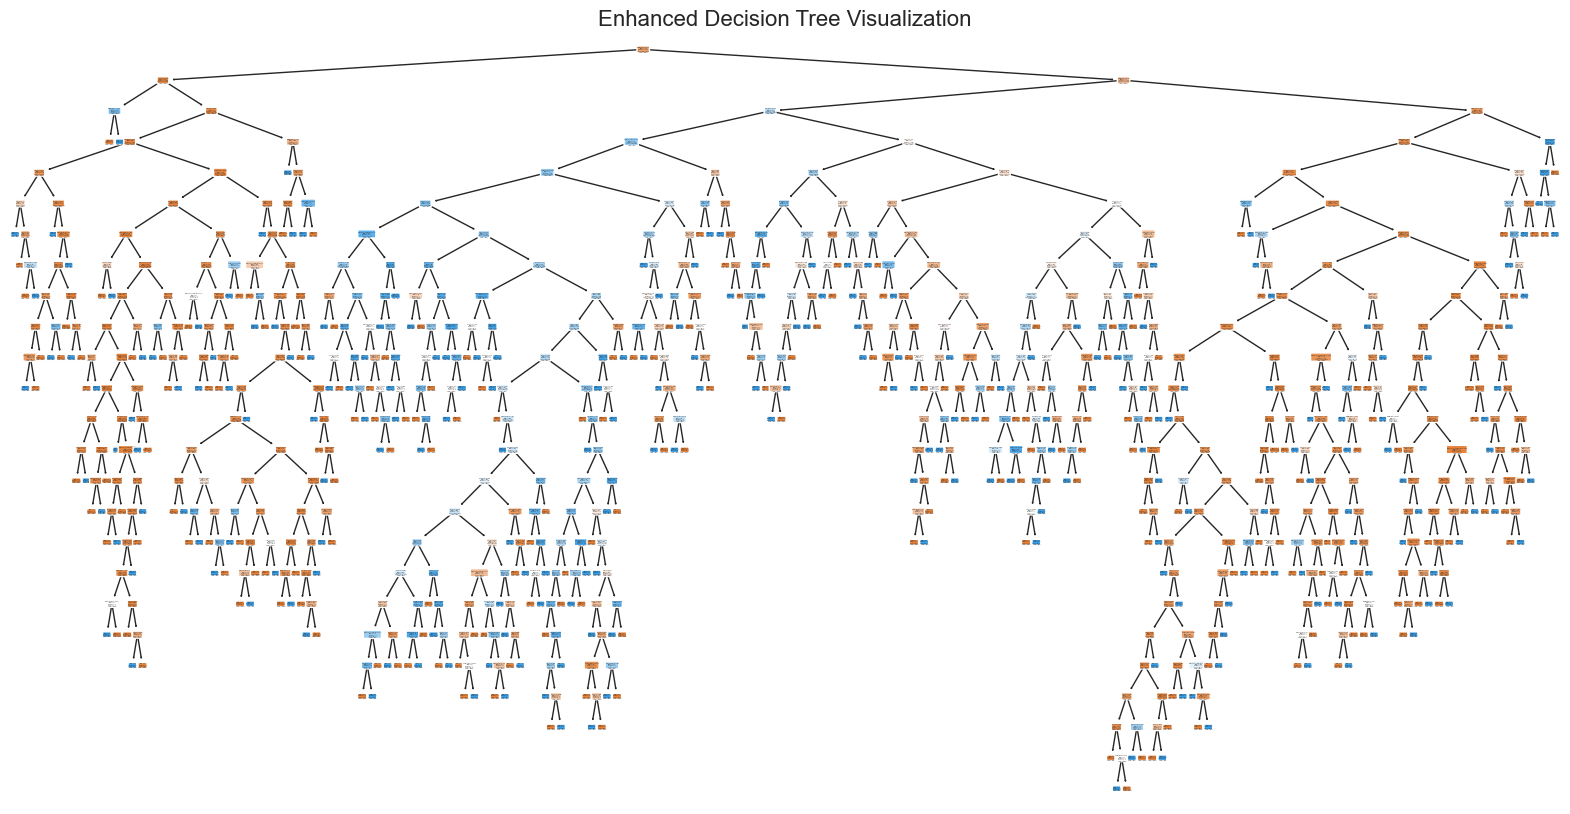

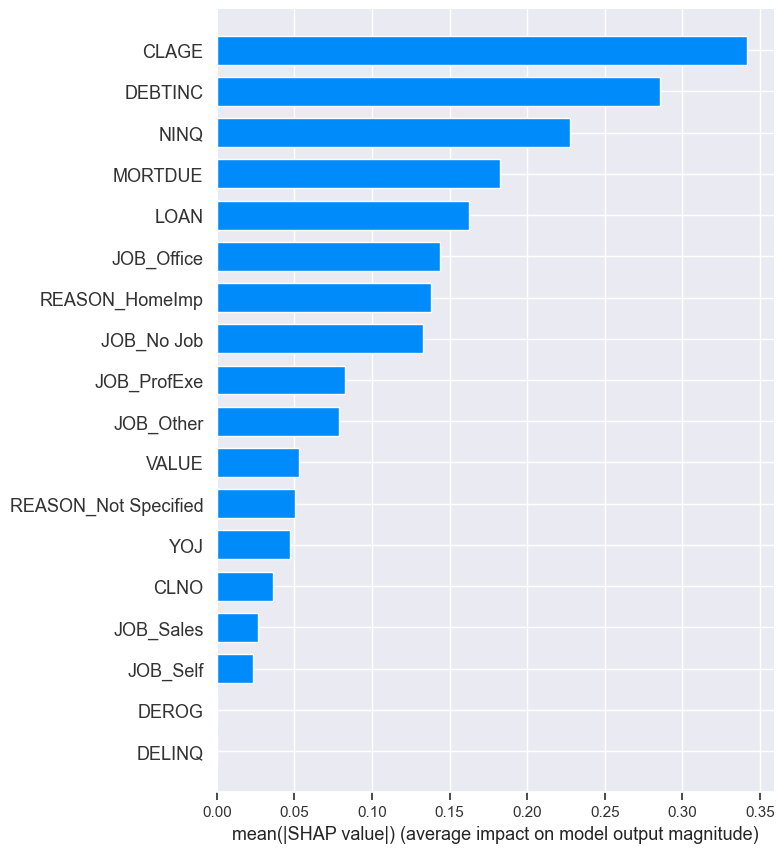

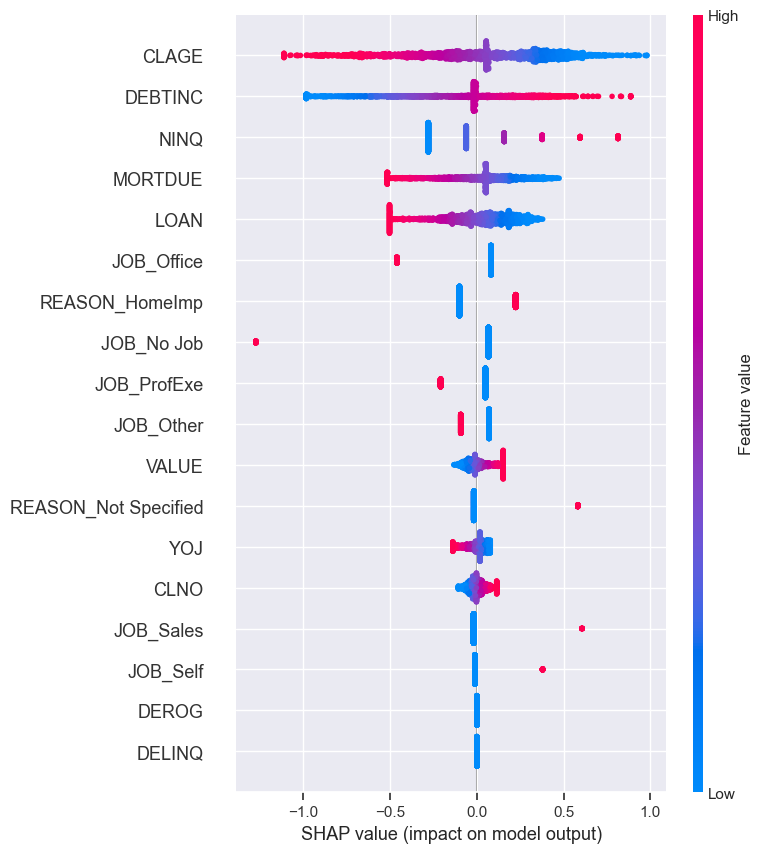

Model: Logistic Regression
Accuracy: 0.8059284116331096
Recall: 0.07282913165266107
Precision: 0.6190476190476191
F1 Score: 0.13032581453634084
AUC: 0.5308240696697966


Model: Decision Tree
Accuracy: 0.860738255033557
Recall: 0.5742296918767507
Precision: 0.6788079470198676
F1 Score: 0.622154779969651
AUC: 0.7532224629893886


Model: Random Forest
Accuracy: 0.9049217002237137
Recall: 0.6610644257703081
Precision: 0.8280701754385965
F1 Score: 0.735202492211838
AUC: 0.813411318405769


Model: XGBoost
Accuracy: 0.8959731543624161
Recall: 0.6358543417366946
Precision: 0.8021201413427562
F1 Score: 0.709375
AUC: 0.7983604343204787




In [ ]:

# define the models 
log_reg=LogisticRegression()
doc_tree=DecisionTreeClassifier()
ran_for=RandomForestClassifier()
xgb_clf=XGBClassifier(use_label_encoder=False,eval_metric='logloss')

# Assuming you have the following models:
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': doc_tree,
    'Random Forest': ran_for,
    'XGBoost': xgb_clf
}

# 1. 📊 Confusion Matrix using Seaborn
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 2. 📈 ROC Curve using Matplotlib
plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(x_train, y_train)
    y_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random guess)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3. 📉 Feature Importance using Seaborn
for name, model in models.items():
    model.fit(x_train, y_train)
    if name == 'Random Forest':
        importances = model.feature_importances_
        feat_imp_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(8, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
        plt.title(f"Feature Importance for {name}")
        plt.show()
    elif name == 'XGBoost':
        xgb.plot_importance(model)
        plt.title(f"Feature Importance for {name}")
        plt.show()

# 4. 🌳 Enhanced Decision Tree Visualization (static)
if 'Decision Tree' in models:
    model = models['Decision Tree']
    model.fit(x_train, y_train)

    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, feature_names=x_train.columns, class_names=['Good', 'Bad'], rounded=True)
    plt.title("Enhanced Decision Tree Visualization", fontsize=16)
    plt.show()

# 5. 📌 SHAP Values Plot (Dot and Bar) for Logistic Regression
explainer = shap.Explainer(log_reg, x_train)
shap_values = explainer(x_test)

# Bar plot
shap.summary_plot(shap_values, x_test, plot_type='bar')

# Dot plot
shap.summary_plot(shap_values, x_test, plot_type='dot')

# 6. Model Evaluation Metrics (Accuracy, Precision, Recall, F1-Score, AUC)
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    print("\n")
